# Blackjack Solver
Shantanu Laghate, November 2024

## Problem Definition
Objective of the game:
- obtain cards the sum of whose numerican values is as great as possible without exceeding 21.
- All face cards count as 10, ace can count as either 1 or 11.
- Player competes independently against dealer.

Gameplay:
- Game begins with two cards dealt to both dealer and player. One of dealer's cards is face up, other is face down.
- If player has 21 immediately (Ace + 10), this is a natural and player wins unless dealer also has a natural in which case it's a draw
- Otherwise, player has two actions:
    + Hit (request additional card)
        * If the player exceeds 21 (goes bust), he loses
    + Stick (stop with current cards)
        * After stick, it becomes the dealer's turn.
- The dealer follows a fixed strategy without choice: stick on any sum 17 or greater, and hits otherwise. If dealer goes bust, player wins. 
- Final outcome decided by whose final sum is closer to 21.

Assumption: cards are dealth from an infinite deck (with replacement), so that there is no advantage to keeping track of the cards already dealt. 

## Formulation as MDP
We can formulate Blackjack as an episodic finite MDP. Each hand of Blackjack is an episode. 
- Rewards: +1, -1, 0 are given for winning, losing, and drawing. All rewards within a game are 0.
- Actions: Hit or Stick
- State: Three variables (Usable Ace, Player's cards and dealer's showing card)
    + Usable ace: if player has ace that can be used as 11 without going bust.
    + Current Sum (12-21) - since if the sum is 11 or lower the player will always hit, there is no decision to make. 
    + Dealer's one showing card (ace-10)
    + Total 200 states


## On-policy Monte Carlo Algorithm with Exploring Starts 
With a Monte Carlo method, we will simulate millions of hands of blackjack to find the optimal policy. We will estimate the Action-Value function, which is the expected return from a given state $s$, if the immediate following action is $a$. This estimate is given by $Q(s, a)$.

Here is the pseudocode for the algorithm:
```
Initialize:
    pi[s], arbitrarily for all s in S, a in A
    Q[s, a] = 0 for all s in S, a in A
    Count[s, a] = 0 for all s in S, a in A

Loop infinitely (for each episode):
    Choose S_0, A_0 randomly such that all pairs have probability > 0
    Generate an episode from S_0, A_0 following pi: S_0, A_0, R_1, ..., S_T-1, A_T-1, R_T
    G = 0
    Loop for each step in the episode t = T-1, T-2, ..., 0:
    G = gamma*G + R_{t+1}
    Unless the pair (St, At) appears earlier in the episode:
        Count[St, At] += 1
        Q(St, At) = Q[St, At] + 1/Count[St, At]*(G - Q[St, At]) # incremental update algorithm
        pi[St] = argmax_a Q[St, a]
```

## Representing State and Action Spaces, Policy
Since there is no decision to be made when `current_sum < 12`, the indexing will correspond to `current_sum-12`.
State is a `(usable_ace, current_sum, dealer_card)` tuple. Action is an enum between `HIT = 0 , STICK = 1`. The action-value function can then be represented by a 4d numpy array: `Q[usable_ace][current_sum][dealer_card][action]`. 

The policy can be represented as a 3d numpy array: `pi[usable_ace, current_sum][dealer_card] in {HIT, STICK}`. 

## Performing the Iteration 
To perform exploring starts, we first select a random state tuple, and random action for our S0, A0. Follow the policy `pi` until the player either goes bust or chooses `STICK`. If the player is not bust, iterate on the dealer until dealer sum is 17 or higher (or dealer goes bust). Finally, compare sums and delegate reward accordingly. All rewards until the last reward will be 0 in the episode. We will keep track of states, actions, and rewards for the entire episode as they are generated. The dealer iteration does not need to be kept track, only the final result is captured in the last reward. 




In [2]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from typing import List, Tuple, Optional
import logging

logging.basicConfig(
    level=logging.DEBUG,  # Set default logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

In [3]:
class Action(Enum):
    HIT = 0
    STICK = 1

## These variables control the offsets between the actual card value (for sums) and 
## the index variable of the action-value table Q.
SUM_OFFSET = 11
DEALER_OFFSET = 2
GAMMA = 1

# Helper Functions

- `random_card_value`: Draws a card from an infinite deck
- `get_next_step`: Transitions between one state to the next; identifies when a player has gone bust.
- `draw_until_stick_or_bust`: Follows a player or dealer policy to generate a sequence of steps and actions (no rewards)

In [4]:
type Rank = int
type IsAce = bool
type UsableAce = bool
type CurrentSum = int
type Step = Tuple[UsableAce, CurrentSum]
type StepSequence = List[Step]
type ActionSequence = List[Action]

def random_card_value() -> Tuple[Rank, IsAce]:
    """
    Assume that cards are drawn from an infinite deck (with replacement). 
    """
    # cards 1, 14, 27, 40 are aces
    card = np.random.randint(1, 53)

    rank = (card % 13) + 1
    is_ace = rank == 1
    
    if is_ace:
        value = 11
    elif rank >= 10:
        value = 10
    else:
        value = rank

    logger.debug(f"Picked card: {value}, {is_ace}")
    return (value, is_ace)
    
def get_next_step(usable_ace: UsableAce, current_sum: CurrentSum, next_card: Tuple[Rank, IsAce]) -> Optional[Step]:
    """
    Given the current state and next card, return next (usable_ace, current_sum) or return None if player went bust
    Note that we're considering (-, 21) to be a terminal state (always STICK). The exploring start is adjusted for this.
    """
    if current_sum == 21:
        logger.debug("Going bust after hitting on 21")
        return None
    value, is_ace = next_card
    logger.debug(f"Old state: {usable_ace}, {current_sum}, Next card: {next_card}")

    next_sum = current_sum + value
    next_usable_ace = usable_ace or is_ace
    if next_sum > 21:
        if (usable_ace or is_ace):
            # if you already have a usable ace and you drew one, you still have one left
            # if you only just drew one, you have none
            # this is a XNOR operation
            next_usable_ace = not (usable_ace ^ is_ace)
            next_sum -= 10
        else:
            # went bust
            logger.debug("Went Bust")
            return None
    
    logger.debug(f"Transitioned from state {usable_ace}, {current_sum} to {next_usable_ace}, {next_sum}")
    return (next_usable_ace, next_sum)


def draw_until_stick_or_bust(usable_ace, start_sum, dealer_card = None, first_action = None, pi = None) -> Tuple[bool, StepSequence, ActionSequence]:
    """
    Follow policy pi until stick or bust
    Can be used by both player or dealer
        For player usage, provide dealer_card and policy pi
        For dealer usage, leave both as None
    Note that dealer_card is only used in this process to select action for the player based on pi
    Output: (end_stick, StepSequence, ActionSequence)
    """
    if pi is not None:
        logger.debug("PLAYER mode")
    else:
        logger.debug("DEALER mode")
        
    state_sequence = [(usable_ace, start_sum)]
    action_sequence = []
    while True:
        cur_usable_ace, cur_sum = state_sequence[-1]
        logger.debug(f"Current step: {cur_usable_ace}, {cur_sum}")
        if pi is not None:
            # player
            if len(state_sequence) == 1 and first_action is not None:
                logger.debug("Doing first action")
                action = first_action
            else:
                logger.debug(f"Indexing pi with {int(cur_usable_ace)}, {cur_sum-SUM_OFFSET}, {dealer_card-DEALER_OFFSET}")
                action = Action(pi[int(cur_usable_ace), cur_sum-SUM_OFFSET, dealer_card-DEALER_OFFSET])
        else:
            # dealer
            if cur_sum >= 17:
                action = Action.STICK
            else:
                action = Action.HIT
        logger.debug(f"Selected action {action}")
        action_sequence.append(action)
        
        if action == Action.STICK:
            logger.debug("Sticking!")
            return (True, state_sequence, action_sequence)
        
        if action == Action.HIT:
            logger.debug("Hitting!")
            next_card = random_card_value()
            next_step = get_next_step(cur_usable_ace, cur_sum, next_card)
            if not next_step:
                # episode ends here
                logger.debug("Went Bust!")
                return (False, state_sequence, action_sequence)
            else:
                state_sequence.append(next_step)


# Monte Carlo Simulation (with exploring starts)

In [7]:
type State = Tuple(int, int, int)
type Reward = int
type Episode = List[Tuple(State, Action, Reward)]


def generate_random_episode_ES(pi) -> Episode:
    # Exploring Start: generate a random starting state and action
    usable_ace = np.random.choice([True, False])
    current_sum = np.random.randint(12, 21)
    dealer_card, dealer_ace = random_card_value()
    first_action = np.random.choice(list(Action))

    logger.debug(f"Starting State: {usable_ace}, {current_sum}, {dealer_ace}, {dealer_card}, {first_action}")

    # handle Natural
    if usable_ace and current_sum == 21:
        # if the dealer also has a natural, it is a tie
        dealer_second_card, dealer_second_ace = random_card_value()
        if dealer_card + dealer_second_card == 21 and (dealer_ace or dealer_second_ace):
            reward = 0
        else:
            reward = +1
        
        state = (usable_ace, current_sum, dealer_card)
        action = Action.STICK
        return [(state, action, reward)]
    
    # Let the player play according to policy pi
    end_stick, step_sequence, action_sequence = draw_until_stick_or_bust(usable_ace, current_sum, dealer_card, first_action, pi)
    if not end_stick:
        # player went bust
        episode = []
        for i in range(len(step_sequence)):
            state = (step_sequence[i][0], step_sequence[i][1], dealer_card)
            action = action_sequence[i]
            reward = -1 if (i == len(step_sequence)-1) else 0
            
            episode.append((state, action, reward))
        return episode

    # let the dealer play
    dealer_stuck, dealer_steps, dealer_actions = draw_until_stick_or_bust(dealer_ace, dealer_card)

    if not dealer_stuck:
        # player wins
        reward = 1

    else:
        if dealer_steps[-1][1] > step_sequence[-1][1]:
            reward = -1
        elif dealer_steps[-1][1] < step_sequence[-1][1]:
            reward = 1
        else:
            reward = 0

    
    episode = []
    for i in range(len(step_sequence)):
        state = (step_sequence[i][0], step_sequence[i][1], dealer_card)
        action = action_sequence[i]
        r = reward if (i == len(step_sequence)-1) else 0
        
        episode.append((state, action, r))
    return episode

In [8]:
def monte_carlo_blackjack(num_episodes=1):
    # initial policy = HIT in all states, except 21
    pi = np.zeros((2, 11, 10))
    pi[:, 10, :] = 1 # Always stick at 21

    # starting action-value estimates 0 for all state-action pairs
    Q = np.zeros((2, 11, 10, 2))
    counts = np.zeros((2, 11, 10, 2))

    for i in range(num_episodes):
        episode = generate_random_episode_ES(pi)

        # keep track of first-visits to action-state pairs
        first_visits = {}
        for t, state_action_reward in enumerate(episode):
            state, action, _ = state_action_reward
            if (state, action) not in first_visits:
                first_visits[(state, action)] = t
        
        G = 0
        for t, state_action_reward in reversed(list(enumerate(episode))):
            state, action, reward = state_action_reward
            G = GAMMA*G + reward
            
            if t == first_visits[(state, action)]: 
                a_state = (int(state[0]), state[1]-SUM_OFFSET, state[2]-DEALER_OFFSET)
                action = action.value
                logger.debug(a_state)
                counts[a_state][action] += 1
                Q[a_state][action] = Q[a_state][action] + 1/counts[a_state][action]*(G - Q[a_state][action])
                pi[a_state] = np.argmax([Q[a_state][0], Q[a_state][1]])

    return pi, Q

In [51]:
logger.setLevel("INFO")
pi, Q = monte_carlo_blackjack(num_episodes=1000000)

# Visualizing the Optimal Policy
There seems to be some variation in the bottom left section of the non-usable ace graph. 

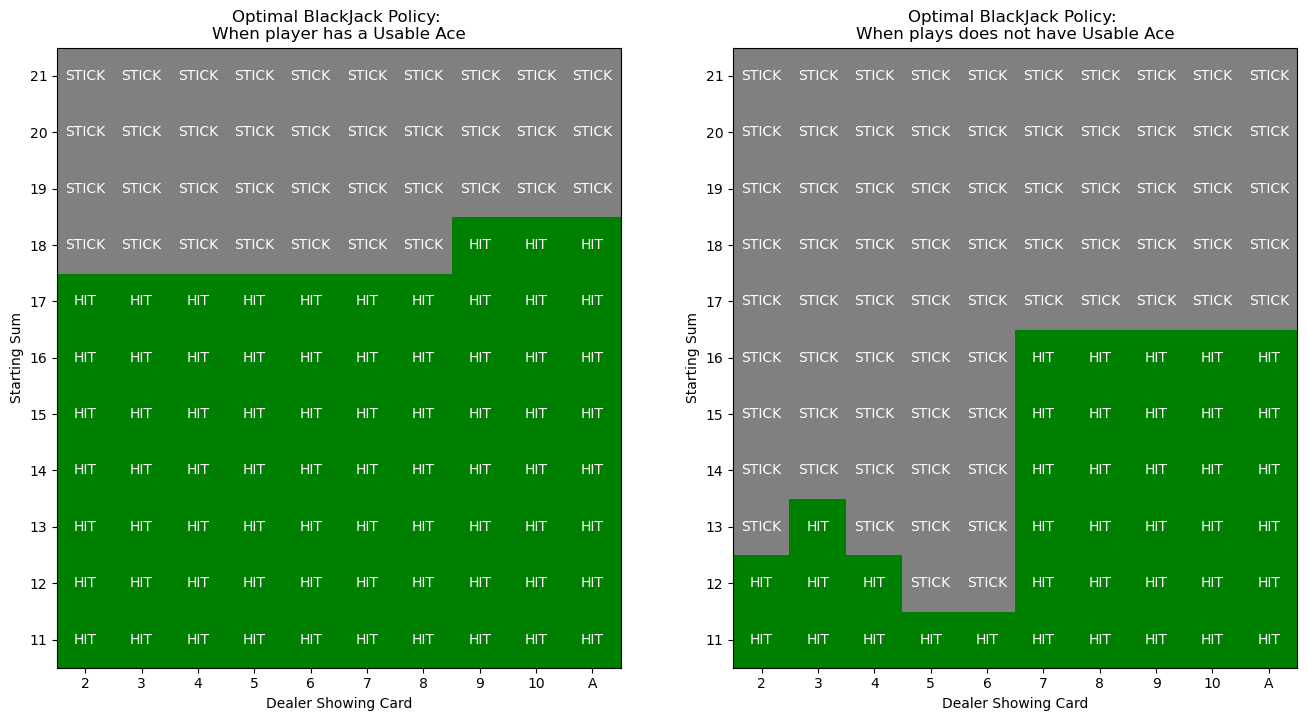

In [55]:
import matplotlib.colors as mcolors
logger.setLevel("WARN")
# Create the heatmap


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))

def plot_policy(fig, ax, pi, usable_ace):
    cmap = mcolors.ListedColormap(['green', 'gray'])
    
    ax.imshow(pi, cmap=cmap)
    
    # Add text annotations
    for i in range(pi.shape[0]):
        for j in range(pi.shape[1]):
            ax.text(j, i, f'{Action(pi[i, j]).name}', ha='center', va='center', color='white')
    
    
    # Optional: Add labels and title
    ax.set_xlabel("Dealer Showing Card")
    ax.set_ylabel("Starting Sum")
    if usable_ace:
        ax.set_title("Optimal BlackJack Policy: \nWhen player has a Usable Ace")
    else:
        ax.set_title("Optimal BlackJack Policy: \nWhen plays does not have Usable Ace")
    
    # Adjust axis ticks and labels
    ax.set_yticks(np.arange(11))
    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(['2', '3', '4', '5', '6', '7', '8', '9', '10', 'A'])
    ax.set_yticklabels(['11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'])

    ax.invert_yaxis()

    

plot_policy(fig, ax1, pi[1], True)
plot_policy(fig, ax2, pi[0], False)


# Display the heatmap
fig.show()
fig.savefig("optimal-policy.png")

# Graph the Value Function
Assuming that you always play optimally, what is your probability of winning from a given state?

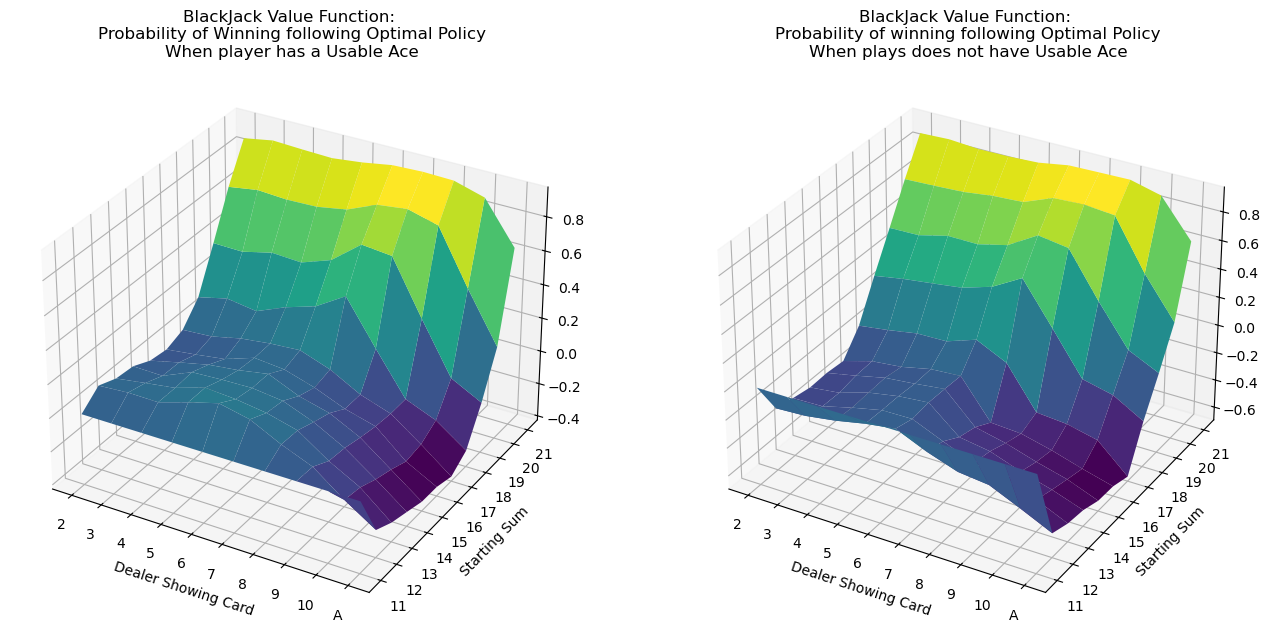

In [104]:
V = np.max(Q, axis=-1)
# Create 3D figure
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')


def plot_value_function(ax, V, usable_ace):
    # Surface plots
    x, y = np.meshgrid(np.arange(V.shape[1]), np.arange(V.shape[0]))
    ax.plot_surface(x, y, V, cmap='viridis')
    
    
    # Optional: Add labels and title
    ax.set_xlabel("Dealer Showing Card")
    ax.set_ylabel("Starting Sum")
    if usable_ace:
        ax.set_title("BlackJack Value Function: \nProbability of Winning following Optimal Policy\nWhen player has a Usable Ace")
    else:
        ax.set_title("BlackJack Value Function: \nProbability of winning following Optimal Policy\nWhen plays does not have Usable Ace")
    
    # Adjust axis ticks and labels
    ax.set_yticks(np.arange(11))
    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(['2', '3', '4', '5', '6', '7', '8', '9', '10', 'A'])
    ax.set_yticklabels(['11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'])
    
plot_value_function(ax1, V[1], True)
plot_value_function(ax2, V[0], False)

# Show plot
fig.show()
fig.savefig("value-function.png")